# Enunciado

Considere el proyecto cuya información se adjunta.  
1.  Dibuje el diagrama Pert y determine el camino crítico.  
2.  Indique el coste de realización para duración PERT
3.  A la vista de la planificación dada, su jefe le dice que el proyeco tiene que ejecutarse en 12 o menos periodos. ¿Con qué probabilidad estima que se verán cumplidos los deseos de su jefe?  
4.  Reduzca la duración del proyecto dos unidades de tiempo con el menor incremento de coste posible.

In [2]:
%%capture
from jupyter_tikz import TexFragment
import os, sys
from IPython.display import display, HTML, Markdown, Math


"""
!apt install libgraphviz-dev              > /dev/null
%pip install pygraphviz "pandas[excel]"   > /dev/null
%pip install numpyarray_to_latex          > /dev/null

repo_url = 'https://github.com/mcasl/pmULE'
repo_name = "pmULE"


if not os.path.exists(repo_name):
    print(f"Cloning repository '{repo_name}'...")
    !git clone {repo_url}
    print("Repository cloned successfully!")
else:
    print(f"Good! No need to download '{repo_name}' again.")

from google.colab import files
"""
# To find local version of the library
sys.path.append('../src')

from pmule import PredecessorTable, ProjectGraph
%cd ~/temp

In [3]:
import pandas as pd
import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, b, m, a, coste_duracion_pert, coste_duracion_tope, duracion_tope
     ('A', '---  ',   6,  2.5, 2, 1600, 1800, 2),
     ('B', '---  ',   2,    2, 2, 2900, 2900, 1),
     ('C', '---  ',   1,    1, 1,  600,  600, 1),
     ('D', '---  ',   1,    1, 1,  600,  600, 1),
     ('E', 'A,B  ',  12,    5, 4, 1600, 2200, 2),
     ('F', 'A,B  ',  12,  2.5, 2, 2000, 2200, 1),
     ('G', 'B,C  ',   6, 1.25, 1,  600,  700, 1),
     ('H', 'B,C  ',  20,   13, 6, 3500, 4900, 3),
     ('I', 'D    ',  30,   12, 6, 3500, 4300, 4),
     ('J', 'E,M  ',   4,    4, 4, 1500, 1500, 2),
     ('K', 'F    ',   7,    7, 7, 2000, 2000, 3),
     ('L', 'J,K,G',   1,    1, 1, 1000, 1000, 1),
     ('M', 'F    ',   3,    3, 3,  500,  500, 1),

] ,columns=['activity', 'predecessors', 'b', 'm', 'a',
            'cost_pert_duration', 'cost_cap_duration', 'cap_duration']).set_index('activity')

datos_enunciado['b'] = datos_enunciado['b'].astype(int)
datos_enunciado

,predecessors,b,m,a,cost_pert_duration,cost_cap_duration,cap_duration
activity,,,,,,,
A,---,6,2.50,2,1600,1800,2
B,---,2,2.00,2,2900,2900,1
C,---,1,1.00,1,600,600,1
D,---,1,1.00,1,600,600,1
E,"A,B",12,5.00,4,1600,2200,2
F,"A,B",12,2.50,2,2000,2200,1
G,"B,C",6,1.25,1,600,700,1
H,"B,C",20,13.00,6,3500,4900,3
I,D,30,12.00,6,3500,4300,4


{{< pagebreak >}}

# Solución
## Apartado 1

> Dibuje el diagrama Pert y determine el camino crítico.

In [4]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='activity', predecessor='predecessors')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L,M
activities,,,,,,,,,,,,,
A,,,,,,,,,,,,,
B,,,,,,,,,,,,,
C,,,,,,,,,,,,,
D,,,,,,,,,,,,,
E,True,True,,,,,,,,,,,
F,True,True,,,,,,,,,,,
G,,True,True,,,,,,,,,,
H,,True,True,,,,,,,,,,
I,,,,True,,,,,,,,,


### Precálculo de variables de interés

A partir de los datos del enunciado podemos calcular la duración media, la desviación típica y el coste unitario de reducción que utilizaremos para contestar las preguntas realizadas.

In [5]:
display(Math(r"$duration=\frac{a+4m+b}{6}$"))
display(Math(r"$standard ~ deviation=\frac{b-a}{6}$"))
display(Math(r"$ucr=\frac{C_{cap}-C_{pert}}{d_{cap}-d_{pert}}$"))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

{{< pagebreak >}}

In [6]:
datos_proyecto['duration'] = datos_proyecto.eval('(b + 4*m +a)/6')
datos_proyecto['standard_deviation'] = datos_proyecto.eval('(b -a)/6')
datos_proyecto['ucr'] = datos_proyecto.eval('(cost_cap_duration - cost_pert_duration)/(duration - cap_duration)').round(2)
datos_proyecto[['b', 'm', 'a', 'duration', 'standard_deviation', 'ucr']]

,b,m,a,duration,standard_deviation,ucr
activity,,,,,,
A,6,2.50,2,3.0,0.666667,200.00
B,2,2.00,2,2.0,0.000000,0.00
C,1,1.00,1,1.0,0.000000,NaN
D,1,1.00,1,1.0,0.000000,NaN
E,12,5.00,4,6.0,1.333333,150.00
F,12,2.50,2,4.0,1.666667,66.67
G,6,1.25,1,2.0,0.833333,100.00
H,20,13.00,6,13.0,2.333333,140.00
I,30,12.00,6,14.0,4.000000,80.00


### Grafo PERT con numeración de nodos

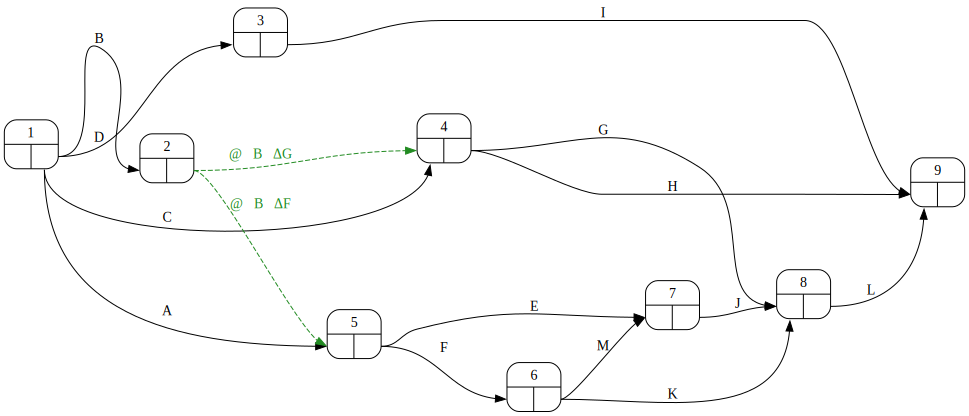

In [7]:
proyecto = prelaciones.create_project()
proyecto.pert(ranksep=1, nodesep=0.6)

### Matriz de Zaderenko

In [8]:
proyecto.zaderenko(datos_proyecto['duration'])

,1,2,3,4,5,6,7,8,9,early
1,,2.0,1.0,1.0,3.0,,,,,0.0
2,,,,0.0,0.0,,,,,2.0
3,,,,,,,,,14.0,1.0
4,,,,,,,,2.0,13.0,2.0
5,,,,,,4.0,6.0,,,3.0
6,,,,,,,3.0,7.0,,7.0
7,,,,,,,,4.0,,10.0
8,,,,,,,,,1.0,14.0
9,,,,,,,,,,15.0
late,0.0,2.0,1.0,2.0,3.0,7.0,10.0,14.0,15.0,


In [9]:
resultados_pert = proyecto.calculate_pert(datos_proyecto['duration'])
resultados_pert['nodes'].T

,1,2,3,4,5,6,7,8,9
early,0,2,1,2,3,7,10,14,15
late,0,2,1,2,3,7,10,14,15


##### Holguras

In [10]:
resultados_pert['activities'].T

,@∇B⤑ΔF,@∇B⤑ΔG,A,B,C,D,E,F,G,H,I,J,K,L,M
H_total,1,0,0,0,1,0,1,0,10,0,0,0,0,0,0


###### Camino crítico

In [11]:
camino_critico = proyecto.critical_path(datos_proyecto['duration'])
for ruta,actividades in camino_critico.items():
    print(ruta + ":\t", ", ".join(actividades))

Route_2:	 A, F, K, L
Route_3:	 A, F, J, L, M
Route_8:	 B, H
Route_11:	 D, I


##### Grafo PERT con indicación de tiempos

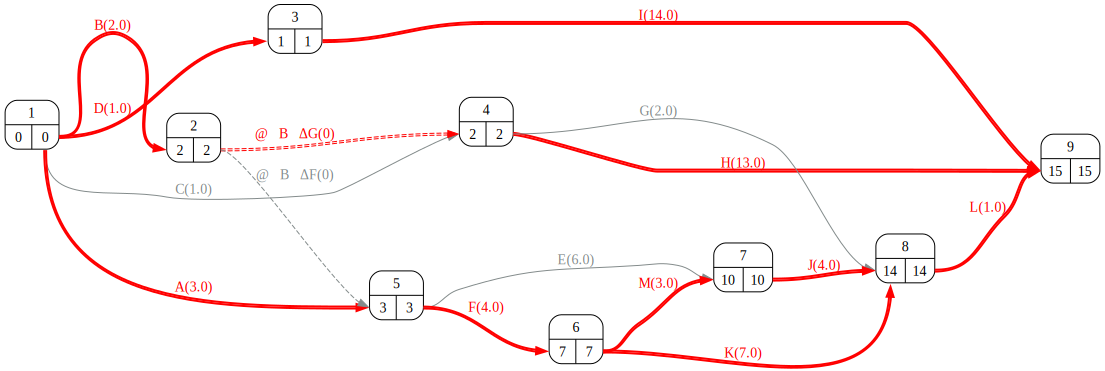

In [12]:
proyecto.pert(durations=datos_proyecto['duration'], ranksep=1)

## Apartado 2
> 2. Indique el coste de realización para duración PERT

Para responder este apartado tan sólo es necesario sumar los costes indicados en la columna coste_duracion_pert.

In [13]:
Markdown(f"La suma de los costes es {int(datos_proyecto['cost_pert_duration'].sum())}")

La suma de los costes es 21900

{{< pagebreak >}}

## Apartado 3
> A la vista de la planificación dada, su jefe le dice que el proyeco tiene que ejecutarse en 12 o menos periodos. ¿Con qué probabilidad estima que se verán cumplidos los deseos de su jefe?


### Duración media del proyecto

La duración media del proyecto ya la tenemos calculada:

In [14]:
duracion_media_proyecto = int(proyecto.duration(datos_proyecto['duration']))

In [15]:
Markdown(f"La media de la duración del proyecto es {duracion_media_proyecto}")

La media de la duración del proyecto es 15

### Desviación típica del proyecto

Calculamos la varianza para cada rama:

In [16]:
datos_proyecto['variance'] = datos_proyecto.eval('standard_deviation ** 2')
desviacion_proyecto = proyecto.standard_deviation(durations=datos_proyecto['duration'],
                                                  variances=datos_proyecto['variance'])

Variance path: Route_2 : 3.2222222222222223
Variance path: Route_3 : 3.2222222222222223
Variance path: Route_8 : 5.4444444444444455
Variance path: Route_11 : 16.0
Project duration variance: 16.0
Project duration standard deviation: 4.0


In [17]:
Markdown(f"La desviación típica de la duración del proyecto es {round(float(desviacion_proyecto), 2)}")

La desviación típica de la duración del proyecto es 4.0

### Cálculo de la probabilidad

Una vez caracterizada la distribución normal con la que aproximamos la duración del proyecto, podemos hacer el cálculo de la probabilidad:

In [18]:
import scipy
from scipy.stats import norm

probabilidad_de_terminar_antes_de_12 = norm.cdf(12, loc=duracion_media_proyecto, scale=desviacion_proyecto)
probabilidad_de_terminar_antes_de_12  = round(float(probabilidad_de_terminar_antes_de_12 * 100), 2)

In [19]:
Markdown(f"La probabilidad pedida es {probabilidad_de_terminar_antes_de_12} por ciento.")

La probabilidad pedida es 22.66 por ciento.

{{< pagebreak >}}

## Apartado 4.

> Reduzca la duración del proyecto dos unidades de tiempo con el menor incremento de coste posible.


Se aborda la solución de este apartado mediante la técnica de reducción de la duración del proyecto con mínimo coste.

In [20]:
ackoff, best_option, durations, available = proyecto.ackoff(durations=datos_proyecto['duration'],
                                                            min_durations=datos_proyecto['cap_duration'],
                                                            costs=datos_proyecto['ucr'],
                                                            reduction=2)
ackoff

Step: 0,	 Critical paths: ['Route_2', 'Route_3', 'Route_8', 'Route_11']
		 Best option: ['K', 'J', 'I', 'B'], 	 Cost: 80.0
Step: 1,	 Critical paths: ['Route_2', 'Route_3', 'Route_8', 'Route_10', 'Route_11']
		 Best option: ['K', 'J', 'I', 'H'], 	 Cost: 220.0

--------------------------------------------------------------------------------


,A,B,C,D,E,F,G,H,I,J,K,L,M,0,1,2
Route_1,200.0,,,,150.0,,,,,0.0,,,,14.0,13.0,12.0
Route_2,200.0,,,,,66.7,,,,,0.0,,,15.0,14.0,13.0
Route_3,200.0,,,,,66.7,,,,0.0,,,0.0,15.0,14.0,13.0
Route_4,,0.0,,,150.0,,,,,0.0,,,,13.0,11.0,10.0
Route_5,,0.0,,,,66.7,,,,,0.0,,,14.0,12.0,11.0
Route_6,,0.0,,,,66.7,,,,0.0,,,0.0,14.0,12.0,11.0
Route_7,,0.0,,,,,100.0,,,,,,,5.0,4.0,4.0
Route_8,,0.0,,,,,,140.0,,,,,,15.0,14.0,13.0
Route_9,,,,,,,100.0,,,,,,,4.0,4.0,4.0
Route_10,,,,,,,,140.0,,,,,,14.0,14.0,13.0
